# Prediction Challenge
This notebook contains our attempt to predict `CO2 Emissions per Capita (metric tonnes)` for each city. The notebook consist of three parts 
* Part 0: **Model Preparation - Nuts and bolts of Machine Leanring ** 
> This part will consist of the preparations before any modeling occur. 
In this part we will argue for our choice of model - namely the *elastic net* model namely because of its regularization properties combined with interpretability. Moreover it will be discussed how we validate it using *cross validation*.
 
* Part 1: **Prediction Challenge 1**
> In this part the first prediction challenges will be considered. That is the training set will consist of the first 75% rows and the remaining 25% of rows will act as the test set. 

* Part 2: **Prediction Challenge 2** 
>In this part the second prediction challenges will be considered. That is the rows with corresponding cities in North and South America will act as the test set while the remaining rows with cities elsewhere will act as the training set.

* Part 3: **Trying out other regression models**
> In this part we will consider other regression models that are implemented in the Sklearn library. Here only the first prediction challenge will be considered as this part will mainly act to show how powerful the library is and how easy to try a different model with the framework. 

In [1]:
# Package import
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import linear_model
from sklearn.metrics import r2_score

# Part 0: Model Preparation - Nuts and bolts of Machine Leanring

## Part 0.1: Choice of model - Elastic Net
We have choosen the Elastic Net models as it is a highly interpretable regression model that work great with highly correlated variables. As it has been previously shown there is a high degree of mulit collinearity accorss the different variables. That is normally a *big* issue for traditional linear regression. But Elastic net allow us to “average” highly correlated features and obtain more robust estimates with it. Elastic net is a linear regression model that utilies both $\ell_1$ and $\ell_2$ regularization. Using $\ell_1$ regularization regression tends to select one variable from a group and ignore the others. Using $\ell_2$ regularization alone leaves all variables, but shrink them, that means a ton of featuers are included in model - this is not desireable. By using a combination of the two we are left with fewer but import features which is exactly what the elastic net does.

## Part 0.2: Setting up Sklearn modelling tools 
1. ** Consideration regarding regularization to combat overfitting**

    As elastic net utilzes regularization is is necessary to standardize the data as features on different scale would confuse the model. Furthermore categorical data does not fit well with many models. Therefore these are *one-hot-encodeded*. However, the prediction challenge in this notebook will not have any categorical data but once the external comes this will be necessary to deal with.

1. ** Consideration features selection**

    The elastic net model has two parameters which we seek to optimize namely the $\alpha$ and $\ell_{1}-\textrm{ratio}$. Where
    $$\alpha = a + b \quad \textrm{and,} \quad \ell_{1}-\textrm{ratio} = \frac{a}{a+b}$$
    and $a$ and $b$ control the level of  $\ell_{1}$ and  $\ell_{2}$ regularization respectivly. I.e.
    $$a \cdot \ell_{1} + b \cdot \ell_{2}$$

    To select the the parameters best suited for the dataset we can validate a given set of parameter on a validation set. However, as there is only little *training* and *testing* data we feel is insufficient to create a separate validation. Instead we will utlize *Cross Validation* - more specifically we will use 5 fold cross validation where 5 folds is chosen due to relatively small data set and to avoid too much correlation between sets. Here we will split the data in into 5 folds train on 4 parts and test on 1 in each of the 5 iteration. This will, *hopefully* provide us with an idea of which choice of parameter generalizes the best. By the *best* we will consider the expected prediction error by measuring the mean squared error in each fold. We optimize over the negative mean squared error rathar than $R-$squared as this measure is typically improved adding additional parameters to the model - even if they don't provide much explantory power. This could however be handled by consider $R^2_{\textrm{adj}}$ but MSE have other advantages over this measures so this will be considered. See https://data.library.virginia.edu/is-r-squared-useless/ for more info. The reason the negative MSE is chosen is since the optimzier in GridSearchCV searches for a maximum and thus the negative has to be used to get the lowest MSE.

In the cell below we will utilze some of `Sklearn`'s amazing features to create function the ensure the above. The functions are briefly explained in the docstrings.

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer



def getPipe(model, numerical_columns, categorical_columns=[]):
    """
    Prepares a pipe that 
        First:  Prepare the data prior to modelling. That is all numerical features 
                is standardized, all categotical are one.hot-encodeded. The features
                not specified as numerical or categorical are dropped if not specified.
        Second: Send the prepared data into the model.

    """
    # Pipeline to handle continous parameters. Here the parameters are scaled.
    # This is important to do each time so test data is not considered for 
    # normalization which would be the case if all data were standardized at once.
    numeric_transformer = Pipeline([
        ('scale', StandardScaler())
    ])
    
    # Pipeline to handle categorical parameters. Here the categorical variables
    # which are missing is imputed by using the most frequent value
    # afterwards they are one-hot encoded.
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(
            missing_values = ' NaN',
            strategy = 'most_frequent')),
        ('hot', OneHotEncoder())
    ])
    
    # Split the data into continous and caterigorical using ColumnTransformer
    # and apply numeric_transformer and categorical_transformer 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='drop'
    )
    
    # Build the final pipeline for model fitting
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipe

def cv(pipe, parameters, X_train, y_train, cf = 5):    
    """
    Performs paramter tunning using cross-validation on a specifed pipe object.
    """
    # perform cross validaiton over the input parameters
    cv_select = GridSearchCV(
        estimator=pipe, 
        param_grid=parameters, 
        scoring='neg_mean_squared_error', # Use MSE
        n_jobs=-1,
        return_train_score=True,
        verbose=10, 
        cv=cf
    )
    cv_select.fit(X_train, y_train)
    
    return(cv_select)

## Part 1: Prediction Challenge 1

For *Prediction Challenge* we will utlize the data we imputed in the previous notebook. The data is loaded in the cell below:

In [3]:
df = pd.read_csv(os.path.abspath('../data/Processed/Cities_imputed.csv'), index_col=0)

Now the data will be splitted into *predictors*: $\mathbf{X}$ and *targets*: $\mathbf{y}$. The below function handles that job. Furthermore the function takes an aditional argument `drop_cols` which is used to delete a list of selected column(s). It will be utilzed to make sure that column **Pollution index** does not play a part in the modelling. 

In [4]:
def split_target_and_predictors(data, target, drop_cols = []):
    X = data.drop(drop_cols+[target], axis = 1)
    y = data[[target]]

    return X, y

X, y = split_target_and_predictors(
    data = df,
    target = 'CO2_Emissions_per_Capita_(metric_tonnes)',
    drop_cols = ['Pollution_Index_']
)

Now, to split the data into a test a training set where the first 75% row will corrosponds to train and last 25% row will corrosponds to test set we utilize `sklearn` function `train_test_split` from the `model_selection` module. Note here the two function arguments `test_size = 0.25`, and `shuffle = False`. The first argument ensure that the testing set will take the size of 25% and hence the training set will take the size of 75%. The second keyword ensure that the dataset is not shuffled. By default the first rows will corrospond to train and the remaing to test. That way the first 25 % will be test set and the remaing 75 training set as the *Prediction Challenge* states*.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.25, shuffle = False)

The following columns bring no information to the model:

1. `City`: Being a name does not bring any information to the model
1. `cityID`: Is the id of every row i.e. the unique identifier therefore not included.
1. `clusterID`: This variable is based on the other variable including the CO2 emision that we have to predict as seen in the article on urban typology found in the docs folder. It feels like *cheating* to include this and it is thus not included. Moreover, it should also introduce more multicoliniarity.
1  `Typology` : Typology is the same variable as clusterID, but instead of id it has a name. It is not included for the same reasons.
1. `Country`: As there are so many countries it feels like overkill to one-hot-encode them therefor this varaible is not included.
1. `Continent`: the feature `Continent` was not in the orignal dataset but something we eniginnered on or own.  It will not be considered such that the prediction challenge is first created on equal basis compared to other groups.
1. `Latitude`: Not included for the same reason as Continent.
1. `Longitude`: Not included for the same reason as Continent.

Furthermore columns that contains missing values i.e. rows that was not suitable to be imputed with KNN-imputer from the previous notebook, will not be considered - it is also so few so it is not deemed a major problem.

In [6]:
colum_names = X_train.columns

no_info_column = ['City', 'cityID', 'clusterID', 'Typology', 'Country', 'Latitude', 'Longitude', 'Continent']
columns_with_nan = df.columns[df.isnull().any()].tolist()
remove_columns = no_info_column + columns_with_nan

numerical_columns = [ column for column in colum_names if column not in remove_columns ]

Now the functions created prevoisly allows us to easily create an elastic net model and fin the optimal parameters to fit the data. In the cell below it can be seen that we search $100 \cdot 25 = 2500$ different set of parameters for $\alpha$ and $\ell_{\textrm{ratio}}$. In total 12500 models will be trained as we ultize 5 fold cross validaiton. The verbose is used to keep track of progression.

In [7]:
elastic_net_model = linear_model.ElasticNet(fit_intercept = True)

parameters = {
    'model__alpha': np.linspace(0, 1, 100),
    'model__l1_ratio': np.linspace(0, 1, 25)
}

elastic_net_pibe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
)
elastic_net_cv = cv(elastic_net_pibe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1992s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 236

As can be seen the gridseach creates 12500 models. In every fold it tries a different combination of $\alpha$ and $\ell_1-\textrm{ratio}$. The average performance over each fold set is seen in the heatmap below:  

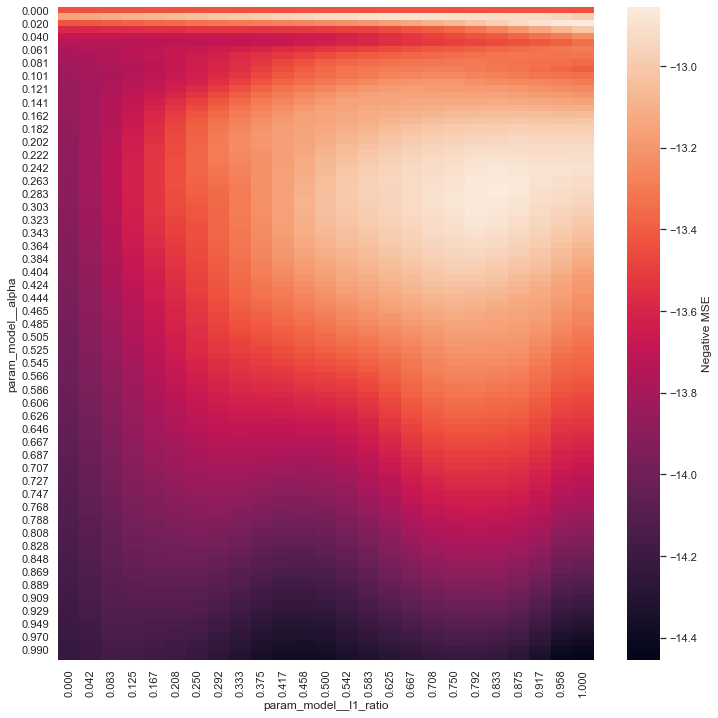

In [8]:
pvt = pd.pivot_table(pd.DataFrame(elastic_net_cv.cv_results_),
    values='mean_test_score', index='param_model__alpha', columns='param_model__l1_ratio')

plt.figure(figsize = (12,12))
ax = sns.heatmap(pvt, cbar_kws={'label': 'Negative MSE'})

# Round ticks
ax.set_xticklabels(['{:.3f}'.format(float(t.get_text())) for t in ax.get_xticklabels()])
ax.xaxis.set_tick_params(rotation=90)
ax.set_yticklabels(['{:.3f}'.format(float(t.get_text())) for t in ax.get_yticklabels()])
ax.yaxis.set_tick_params()

The hyperparameters performing the best on average on the validatons folds are shown below:

In [9]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f' alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

 alpha = 0.02, l1-ratio: 1.0


The best suited model is the one with exclusively $\ell_1$ regualzation i.e. a lasso model. This must be due to the large amount of variables combined with multioliniarity. $\alpha$ get a very low value of 0.02, which is the second smallest non-zero value tested. Looking at the heat map the is seems to be a band of optimal values with a very low $\alpha$ but we also find low training error at an $\ell_1$-ratio of around 0.8 and $\alpha=0.25$. It is not investigated why this happens but instead we progress with the optimal model.

In the next section "Part 1.1 Coefficients Analysis" we will dive into what happens to the coefficients using this regualzation.

Using the above parameters and the full training set the final elastic model is tried on the testing set. The $R^2$ is calculated below:

In [10]:
y_pred = elastic_net_cv.predict(X_test)
print('R2: ', round(r2_score(y_test, y_pred),4))

R2:  0.6426


We get a score of $R^2 \approx 0.64$ which must be deemed good based on the benchmarks. It is here important to remember that the optimization is carried out on the MSE. Optimizing on $R^2$ directly lead to results close to 0.7 but of the previously mentioned reasons we will stick with the MSE. Let's look at the training and test MSE.

In [11]:
print('Train mse: ', round(mean_squared_error(y_train, elastic_net_cv.predict(X_train)),4))
print('Test mse: ', round(mean_squared_error(y_test, y_pred),4))

Train mse:  7.3825
Test mse:  18.1229


On its own it is hard to judge if 18.1 is a good MSE but comparing it with the training MSE it becomes clear that we overfit on the training data as the error is much lover. Again looking at the size of the data set it can not be excluded that it is due to a not completely representative training data.

### Part 1.1 Coefficients Analysis

One the advantages of using elastic net linear regresison model is its power to be interpretted. In the below is function created that help display the coefficient such that they can be easier compared. 

In [12]:
def plot_coef(model, df):
    # get the column transformer object from the pipe object:
    ColumnTransformer = model.get_params()['estimator__steps'][0][1]

    # exstract the numerical and categorical columns
    numerical_features = ColumnTransformer.transformers[0][2]
    categorical_features = ColumnTransformer.transformers[1][2]

    # One hot encode the the names if there is categorical columns
    if categorical_features:
        one_hot_names = [value.replace(" ", "_") for column in categorical_columns for value in df[column].value_counts().index]
    else:
        one_hot_names = []

    names = numerical_columns + one_hot_names

    coef_df = pd.DataFrame({
        'variable' : names,
        'coefficient' : model.best_estimator_.steps[-1][1].coef_,
        'feature' : np.concatenate((
            np.repeat('numeric_feature', len(numerical_columns)),
            np.repeat('categorical_feature', len(one_hot_names))
        ))
    })

    # Define figure, axes, and plot
    color_dict = {'numeric_feature': 'tab:blue', 'categorical_feature': 'tab:red'}

    # Manuelly adding legends...
    from matplotlib.lines import Line2D
    if len(coef_df['feature'].value_counts()) == 2:
        custom_lines = [Line2D([0], [0], color='tab:blue', lw=6),
                        Line2D([0], [0], color='tab:red', lw=6)]
    else:
        custom_lines = [Line2D([0], [0], color='tab:blue', lw=6)]


    fig, ax = plt.subplots(figsize=(20, 10))
    coef_df.plot(
        x = 'variable', y = 'coefficient', kind = 'bar',
        ax = ax, color = [color_dict[x] for x in coef_df.feature],
        legend = False
    )


    plt.title('Coefficients of Features',fontsize=20)
    ax.set_ylabel('Coefficients',fontsize=12)
    ax.set_xlabel(None)
    ax.legend(custom_lines, ['Numerical Feature', 'Categorical Feature'], loc = 2)
    plt.show()

Using the function we can display coefficient of the model. As the coefficient has been standardized prior to modelling using the pipe object the coefficients can be easily compared based on their impact on the $CO_2$ emission.

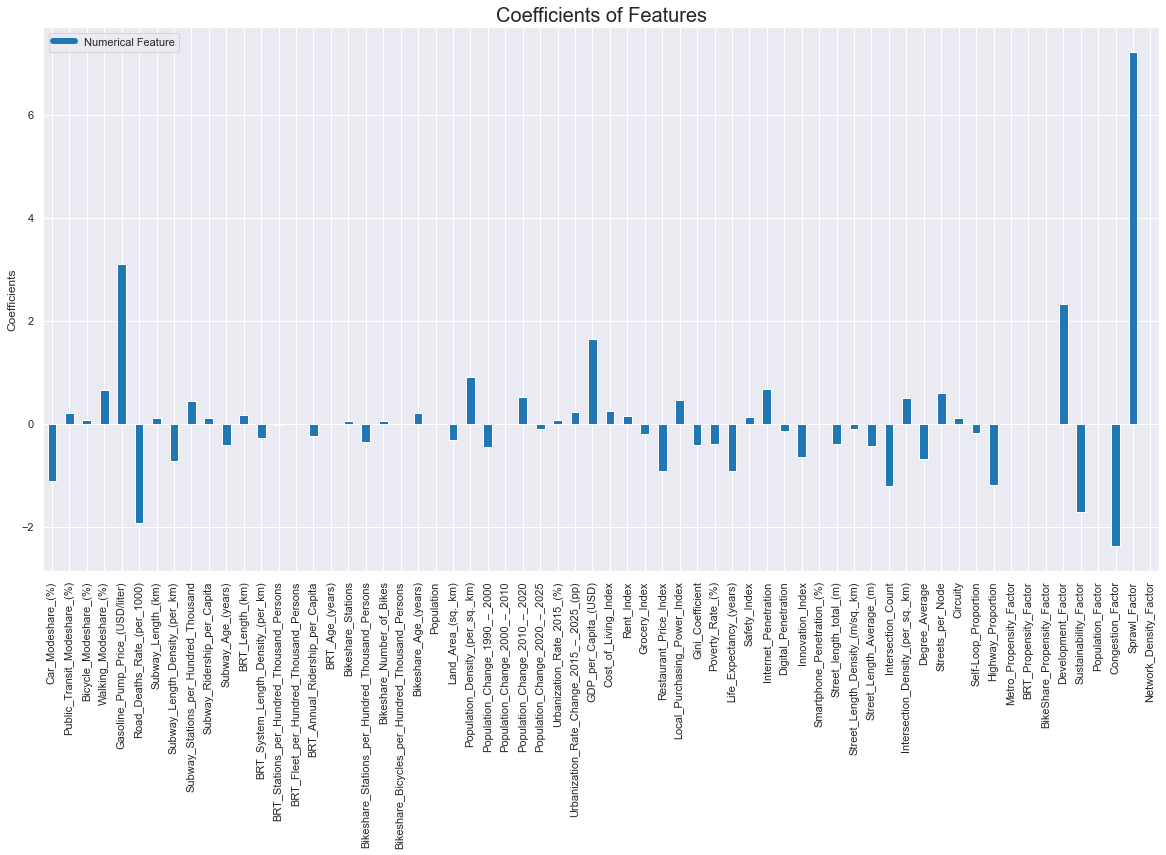

In [13]:
plot_coef(elastic_net_cv, X_train)

It can be seen from the coefficients that a handfull of them gets regualized to 0. It is though not the case for so many but recall that the regualization factor, $\alpha$, only is 0.02 meaning they are not penalized that much for being non-zero. Let's try to make sense of some of the more significant variables. The ones with the largest poisitive coefficients are 

* Gasoline Pump Price
* GPD PerCapita
* Development Factor
* Sprawl Factor

The first three of those are too some degree linked how wealthy a country is. It might seem counter intuitive that greater gasolin prices leads to larger $CO_2$ emissions but it probably comes from the fact that gas is more expensive in rich countries that also emits lots of $CO_2$ in other ways. The variable with the - by far - largest impact is the Sprawl factor. Cities with large values here are the ones being throne to urban sprawl, i.e. large metropolitan areas with low density. This means that public transit is not a viable option for many and they are then forces to drive long distances in their car.

On the opposite side some of the parameters with large negative values are:

* Road Deaths
* Sustainability Factor
* Congestion Factor

It is not surprising to see the sustainability factor in their as a larger value here will lead to less $CO_2$ emitted. It is interesting to see the road deaths in there. It might be because more road deaths happens in poorer countries that does not emit as much $CO_2$ - thus it act opposite of the Gasoline Pump Price. The congenstion factor is also quite surprising. The source of the variable was investigated a bit further and it turned out to come from (TomTom)[https://www.tomtom.com/en_gb/traffic-index/ranking/]. Looking a bit closer at the values (not for 2019 instead of 2016) it does seem odd that there are so many American cities scoring low as the US often is known for its love - in a transit setting - towards the car. As a closing note it must be concluded that it is surprising that a larger congestion factor leads to lower $CO_2$ emissions but again it can be due to some correlations with other variables. This could easily happen due to the very low regualization factior.

## Part 2: Prediction Challenge 2
In this part the test correspond to all cities that belong to North America and South America, while the train set will be the remaining ones. In the cell below the data is splitted accordingly.

In [14]:
X_test = X[(X['Continent'] == 'North America') | (X['Continent'] == 'South America')] 
y_test = y[(X['Continent'] == 'North America') | (X['Continent'] == 'South America')]

X_train = X[(X['Continent'] != 'North America') & (X['Continent'] != 'South America')] 
y_train = y[(X['Continent'] != 'North America') & (X['Continent'] != 'South America')]

We will utlize the same variables to fit the model on as previously, as well as search of the same grid of $\alpha$ and $\ell_{\textrm{ratio}}$ as in part 1.

In [15]:
colum_names = X_train.columns

no_info_column = ['City', 'cityID', 'clusterID', 'Typology', 'Country', 'Latitude', 'Longitude', 'Continent']
columns_with_nan = df.columns[df.isnull().any()].tolist()
remove_columns = no_info_column + columns_with_nan

numerical_columns = [ column for column in colum_names if column not in remove_columns ]

The model is now run:

In [16]:
elastic_net_model = linear_model.ElasticNet(fit_intercept = True)

parameters = {
    'model__alpha': np.linspace(0, 1, 100),
    'model__l1_ratio': np.linspace(0, 1, 25)
}

elastic_net_pibe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
)

elastic_net_cv = cv(elastic_net_pibe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0399s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 276

Let's have a look at the heatmap from the optimization again:

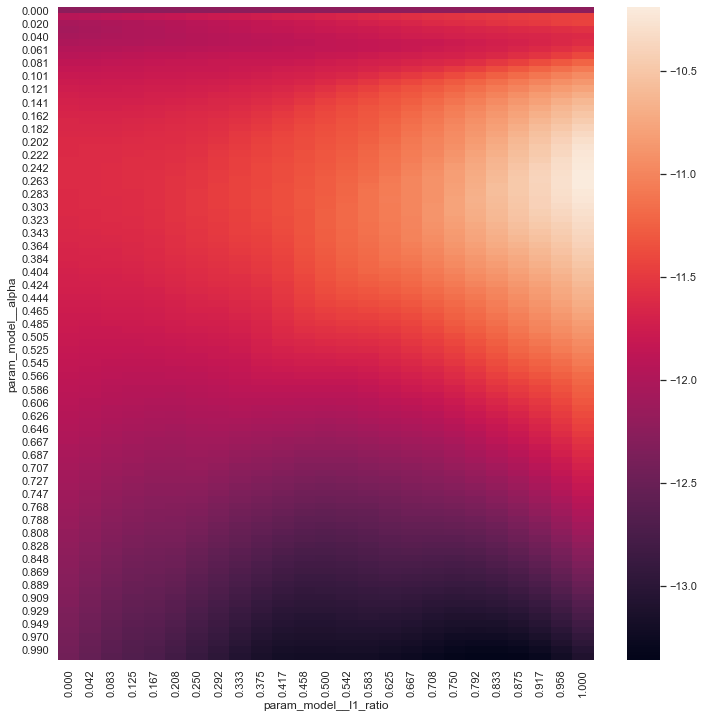

In [17]:
pvt = pd.pivot_table(pd.DataFrame(elastic_net_cv.cv_results_),
    values='mean_test_score', index='param_model__alpha', columns='param_model__l1_ratio')
plt.figure(figsize = (12,12))
ax = sns.heatmap(pvt, cbar_kws={'label': 'Negative MSE'})

# Round ticks
ax.set_xticklabels(['{:.3f}'.format(float(t.get_text())) for t in ax.get_xticklabels()])
ax.xaxis.set_tick_params(rotation=90)
ax.set_yticklabels(['{:.3f}'.format(float(t.get_text())) for t in ax.get_yticklabels()])
ax.yaxis.set_tick_params()

Definitly a different look and there does not seem to be the same minima at very low $\alpha$-values. Let's look at the actual optimum:

In [18]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f' alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

 alpha = 0.263, l1-ratio: 1.0


This time the best suited model is once again with full $\ell_1$ regualzation which corresponds to a lasso model. The $\alpha$ is now 0.263 which is much higher than before meaining much stronger regualzation. This time the predictive performance in terms of R-squared becomes:

In [19]:
y_pred = elastic_net_cv.predict(X_test)
print('R2: ', r2_score(y_test, y_pred))

R2:  0.574893262375113


We get a score of $R^2 \approx 0.57$ for second prediction challenge. This is worse that what was found in part 1 but not too bad consider that the training data on purpose has been made unrepresentative of the test data. The fact that the prediction becomes worse is an indication of the importance to train the model on compareable data to what you want to predict - the model should generalize to the test data so to say. In this case the parameters are not fully transferable to the test data.

Let's look at the MSE.

In [20]:
print('Train mse: ', round(mean_squared_error(y_train, elastic_net_cv.predict(X_train)),4))
print('Test mse: ', round(mean_squared_error(y_test, y_pred),4))

Train mse:  8.585
Test mse:  25.8642


This is an interesting result when comparing to before. Even though the trainign MSE is very compareable to part 1 the test MSE becomes quite a bit worse which is a clear indication of the generalization issue for the model. Ideally these numbers should be compareable but they are clearly not!

### Part 2.2 Coefficients Analysis

In the same manner as before the coefficients of the optimal model is investigated.

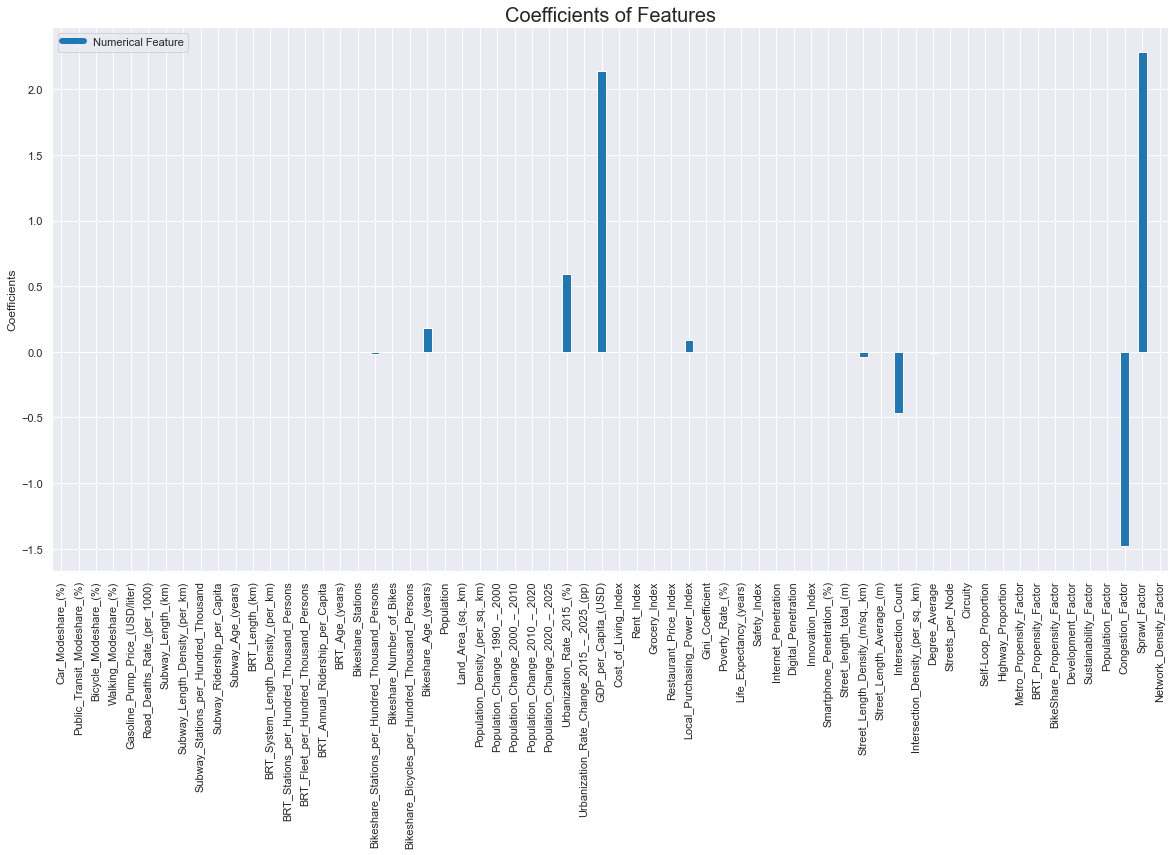

In [21]:
plot_coef(elastic_net_cv, X_train)

Now the stronger regualization becomes very clear with most variables being set to 0. Compared to part 1 some variables looses their importance while others are introduced. It is now seen that the urbanization rate 2015 leads to larger emission while the intersection count leads to a lower one. The intersection could be due to the fact that more intersections ofter are connected with longer time in traffic making public transit (especially rail) more advantagous. The GDP, congestion and sprawl have compareable impace to the part 1.

## Part 3: Trying out other regression models
This part is to illustratehow gow easy it to try out a lot of different models and hyperparemter tune them. More specifically we will try the following model from Sklearn: 

* GradientBoostingRegressor
* RandomForestRegressor
* SGDRegressor
* KNeighborsRegressor
* SVR

These are all relevant models as they are regressors. It should be stated that these models were attempted before settling on the elastic net as the ideal model. 

We have decided not to consider deep learning for this problem due to the size of the data. The reason deep learning is gaining traction is due to the fact that more and more data becomes available. This is though not the case for this dataset where the training set only contains around 250 observations. 
They will applied to part 1 prediction challenge.

In [22]:
X, y = split_target_and_predictors(
    data = df,
    target = 'CO2_Emissions_per_Capita_(metric_tonnes)',
    drop_cols = ['Pollution_Index_']
)

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.25, shuffle = False)


colum_names = X_train.columns
no_info_column = ['City', 'cityID', 'clusterID', 'Country', 'Latitude', 'Longitude', 'Typology']

columsn_with_nan = ['Bicycle_Modeshare_(%)', 'Congestion_(%)', 'Congestion_AM_Peak_(%)',
       'Congestion_PM_Peak_(%)', 'Traffic_Index', 'Travel_Time_Index',
       'Inefficiency_Index', 'Unemployment_Rate_(%)', 'Cost_of_Living_Index',
       'Rent_Index', 'Grocery_Index', 'Restaurant_Price_Index',
       'Local_Purchasing_Power_Index', 'Poverty_Rate_(%)', 'Safety_Index',
       'Pollution_Index_']

remove_columns = no_info_column + columsn_with_nan

categorical_columns = ['Continent']

numerical_columns = [ column for column in colum_names if column not in remove_columns+categorical_columns ]

In [23]:
# Import new models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import pickle

In [24]:
models = {
    'GBR': {
        'model' : GradientBoostingRegressor(),
        'parameters' : {
            'model__n_estimators':[100, 200, 300, 400, 500], 
            'model__learning_rate': [0.1, 0.05, 0.02],
            'model__max_depth': [3], 
            'model__min_samples_leaf':[3], 
        }
    },
    'RFR' : {
        'model' : RandomForestRegressor(),
        'parameters' : {
            'model__max_depth': [10, 20, None],
            'model__min_samples_leaf': [2],
            'model__min_samples_split': [2, 5, 10],
            'model__n_estimators': [100, 150, 200, 250]
        }
    },
    'SGDR' : {
        'model' : SGDRegressor(),
        'parameters' : {
            'model__penalty': ['elasticnet'],
            'model__alpha': np.logspace(-5, 1, 20),
            'model__l1_ratio': np.linspace(0, 1, 10)
        }
    },
    'KNNR' : {
        'model' : KNeighborsRegressor(),
        'parameters' : {
            'model__n_neighbors': np.linspace(5, 30, 6, dtype=np.int),
            'model__weights': ['uniform', 'distance'],
        }
    },
    'SVR' : {
        'model' : SVR(),
        'parameters' : {
            'model__kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
            'model__C' : [1,5,10],
            'model__degree' : [3,8],
            'model__gamma' : ('auto','scale')
        },
    } 

}
for key in models:
    print('Fitting ', key)
    pipe = getPipe(
        model = models[key]['model'],
        numerical_columns = numerical_columns,
        categorical_columns = categorical_columns
    )
    pipe_cv = cv(pipe, models[key]['parameters'], X_train, y_train, cf = 5)
    
    y_pred = pipe_cv.predict(X_test)
    r2 =  r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    models[key]['model_object'] = pipe_cv
    models[key]['r2'] = r2
    models[key]['mse'] = mse
    

Fitting  GBR
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   11.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   12.8s finished
Fitting  RFR
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapse

In [25]:
pickle.dump(models, open('models.pickle', 'wb'))

In [26]:
# read models
saved_model = pickle.load(open('models.pickle','rb'))

Below is predictive power on the test set displayed in terms of mse and $R^2$. The KNNR performs poorly but besides that the remaining models are compareable in performance - again remeber the limited size of observations in the data. None of them does though reach the performance of the elastic net. Compared with the easy interpretability of the elastic net is was easy to see as the chosen model since it thus can help locating key factors for $CO_2$ emision that possibibly can be dealt with. Some of these other models are also interpretable but not as easy.

In [27]:
for model in saved_model:
    print(model, ' mse: ', saved_model[model]['mse'])

GBR  mse:  19.40727672974308
RFR  mse:  20.80135046348361
SGDR  mse:  21.512236853390373
KNNR  mse:  27.371528687978934
SVR  mse:  21.73216911955555


In [28]:
for model in saved_model:
    print(model, ' r2: ', saved_model[model]['r2'])

GBR  r2:  0.617270760705162
RFR  r2:  0.5897783522098619
SGDR  r2:  0.5757590227066611
KNNR  r2:  0.4602084311483048
SVR  r2:  0.5714217573552178


## Sub conslusion

By trying out some different Regression Machine Learning models the elastic net was found to be the ideal one when looking at performance and interpretability. More over in the analysis above it was found that the performance of the models dependent highly on the training/test-split as it was much more difficult to predict the CO$_2$ emission for Americas than the first 75%/25% split. Looking at the world map in the descriptive analyze the reason is relieved to some degree; many of the cities in America is of a different *type* (based on the typology). Auto-sprawl, Auto-innovative, and BusTransit-Dense accounts for most of the American cities but they are almost also exclusively in America. This means the parameters learned on the rest of the World does not transfer well to cities in the Americas, judging by the model performance.

For this reason, it is desired to get new data that should be able to better transfer around the World. Here it is hypothesized that using geographical and meteorological data can help as it is pretty much not affected by the different demographics and mobility cultures around the world. Therefore this data will be found and processed in the next part.